## Netflix_EDA

In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max.columns', None)

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# 데이터 프레임 읽어오기 (UTF-8 인코딩, 오류 무시)
df = pd.read_csv('../data/netflix_titles.csv') 

In [2]:
df['date_added']

0       September 25, 2021
1       September 24, 2021
2       September 24, 2021
3       September 24, 2021
4       September 24, 2021
               ...        
8802     November 20, 2019
8803          July 1, 2019
8804      November 1, 2019
8805      January 11, 2020
8806         March 2, 2019
Name: date_added, Length: 8807, dtype: object

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


## Preprocessing for EDA

In [4]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

### listin 인코딩

In [6]:
# 'listed_in' 컬럼의 요소를 쪼개어 새로운 컬럼 생성
listed_in_split = df['listed_in'].str.split(', ')

# 새로운 컬럼의 초기화
for genre in set(df['listed_in'].str.split(', ').sum()):
    df[genre] = 0

# 각 요소가 포함되어 있는지 여부를 1 또는 0으로 인코딩
for index, row in df.iterrows():
    for genre in listed_in_split[index]:
        df.at[index, genre] = 1

df.rename(columns = {"Kids' TV" : "Kids_TV"}, inplace = True)

### 구간화

In [7]:
def assign_period(df):
    # 'date_added' 열을 datetime 형식으로 변환
    df['date_added'] = pd.to_datetime(df['date_added'])

    # 정체기 기간 설정
    stagnation_mask = (df['date_added'] >= '2015-01-01') & (df['date_added'] <= '2020-01-31')
    df.loc[stagnation_mask, 'period'] = 's'

    # 펜데믹 기간 설정
    pandemic_mask = (df['date_added'] >= '2020-02-01') & (df['date_added'] <= '2022-04-30')
    df.loc[pandemic_mask, 'period'] = 'p'

    # 회복 기간 설정
    recovery_mask = (df['date_added'] >= '2022-05-01') & (df['date_added'] <= '2024-03-31')
    df.loc[recovery_mask, 'period'] = 'r'

    return df


In [8]:
df = assign_period(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   show_id                       8807 non-null   object        
 1   type                          8807 non-null   object        
 2   title                         8807 non-null   object        
 3   director                      6173 non-null   object        
 4   cast                          7982 non-null   object        
 5   country                       7976 non-null   object        
 6   date_added                    8797 non-null   datetime64[ns]
 7   release_year                  8807 non-null   int64         
 8   rating                        8803 non-null   object        
 9   duration                      8804 non-null   object        
 10  listed_in                     8807 non-null   object        
 11  description                   

## World

### Top 20 Countries

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_top_countries(df):
    # 'country' 열의 값 카운트
    country_counts = df['country'].value_counts()

    # 상위 30개 국가만 선택
    top_30_countries = country_counts[:20]

    # Seaborn의 barplot을 사용하여 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_30_countries.index, y=top_30_countries.values, palette='viridis')

    # x축 라벨 회전
    plt.xticks(rotation=90)

    # 그래프에 제목 추가
    plt.title('Top 20 Countries by Production')

    # y축 라벨 추가
    plt.ylabel('Count')

    plt.show()


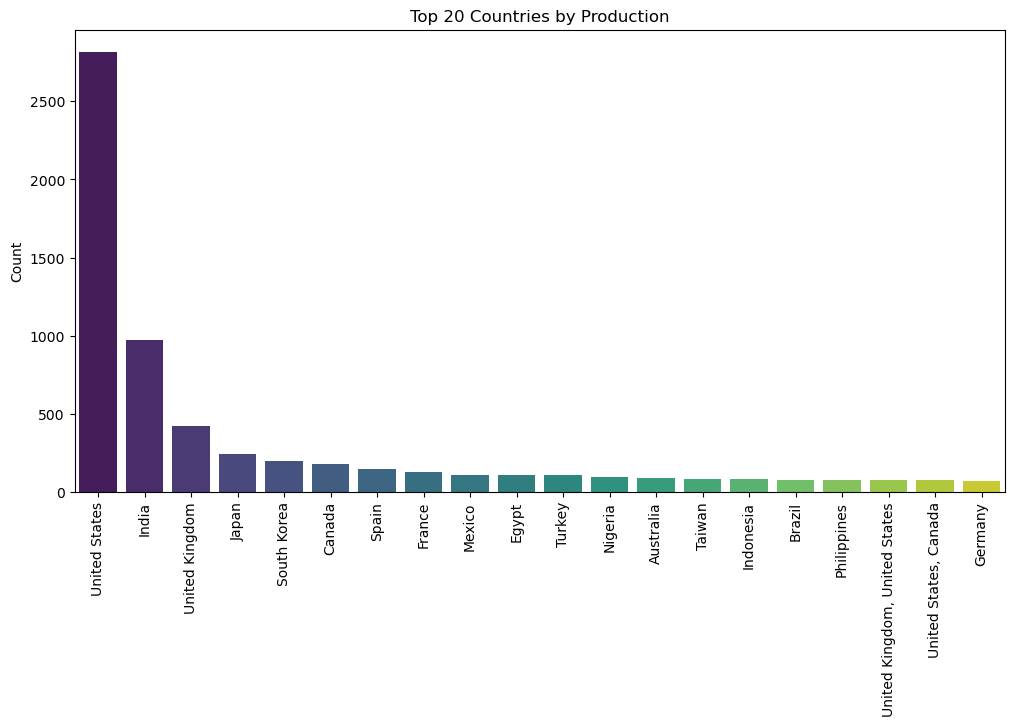

In [11]:
visualize_top_countries(df)

### Distribution of Types

In [12]:
df['type'].value_counts(normalize= True)

Movie      0.696151
TV Show    0.303849
Name: type, dtype: float64

In [13]:
def visualize_type_distribution(df):
    # Seaborn의 countplot을 사용하여 'type' 열의 값 카운트 및 시각화
    sns.countplot(data=df, x='type', palette=['#FF0000', '#000000'])  # 빨간색, 검정색

    # 그래프에 제목 추가
    plt.title('Distribution of Types')
    plt.show()


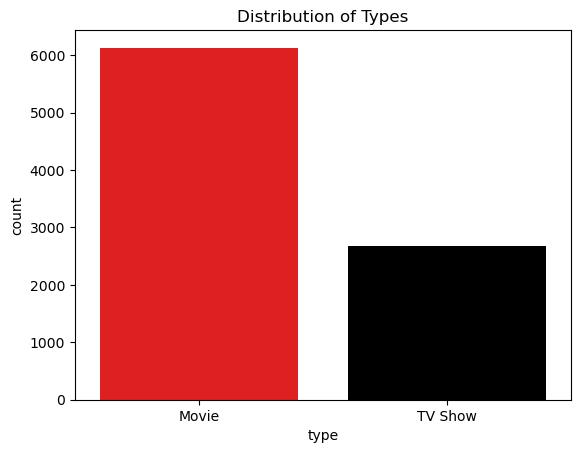

In [14]:
visualize_type_distribution(df)

### Monthly Resampling & Cumulative Total show ID

In [15]:
df.set_index('date_added',inplace = True)

In [16]:
def visualize_cumulative_total(df): #monthly로 계산한 후, 
    # 누적 합계 계산
    monthly_sum_df = df.resample('M').agg({
    'show_id' : 'count'})
    monthly_cumsum_df = monthly_sum_df.cumsum()

    # 새로운 Figure 및 Axes 생성
    fig, ax = plt.subplots(figsize=(10, 6))

    # 누적 합계 시각화
    ax.plot(monthly_cumsum_df.index, monthly_cumsum_df['show_id'], marker='o', linestyle='-')

    # 축 레이블 및 제목 추가
    ax.set_title('Cumulative Total Show ID')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Total Show ID')

    # x 축 눈금 라벨 회전
    plt.xticks(rotation=45)

    # 그리드 추가
    #ax.grid(True)

    # 그림 저장
    plt.tight_layout()

    # 결과 표시
    plt.show()

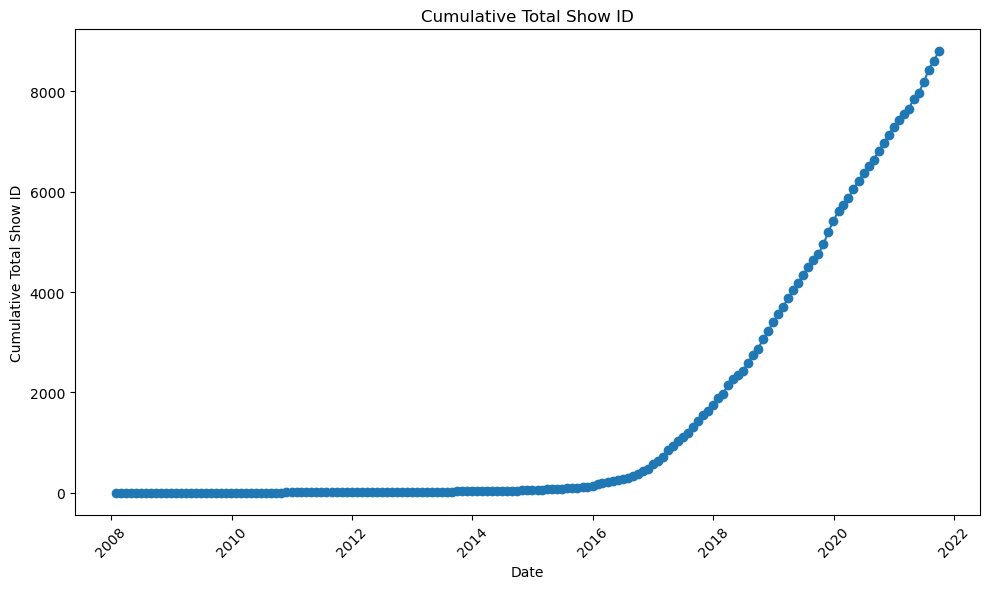

In [17]:
visualize_cumulative_total(df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8807 entries, 2021-09-25 to 2019-03-02
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   show_id                       8807 non-null   object
 1   type                          8807 non-null   object
 2   title                         8807 non-null   object
 3   director                      6173 non-null   object
 4   cast                          7982 non-null   object
 5   country                       7976 non-null   object
 6   release_year                  8807 non-null   int64 
 7   rating                        8803 non-null   object
 8   duration                      8804 non-null   object
 9   listed_in                     8807 non-null   object
 10  description                   8807 non-null   object
 11  International TV Shows        8807 non-null   int64 
 12  TV Thrillers                  8807 non-null   int64 
 13  

In [19]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'International TV Shows', 'TV Thrillers', 'Science & Nature TV',
       'TV Mysteries', 'LGBTQ Movies', 'TV Shows', 'TV Sci-Fi & Fantasy',
       'TV Action & Adventure', 'Horror Movies', 'Anime Series', 'TV Horror',
       'Faith & Spirituality', 'Independent Movies', 'Classic Movies',
       'Cult Movies', 'Thrillers', 'Stand-Up Comedy', 'Docuseries',
       'Action & Adventure', 'Classic & Cult TV', 'Documentaries', 'Movies',
       'Korean TV Shows', 'International Movies', 'Music & Musicals',
       'Sci-Fi & Fantasy', 'Crime TV Shows', 'Teen TV Shows', 'TV Dramas',
       'Sports Movies', 'TV Comedies', 'British TV Shows', 'Romantic Movies',
       'Kids_TV', 'Anime Features', 'Comedies', 'Spanish-Language TV Shows',
       'Stand-Up Comedy & Talk Shows', 'Dramas', 'Reality TV',
       'Romantic TV Shows', 'Children & Family Movies', 'p

In [20]:
stagnation_df = df[df['period'] == 's']
pandemic_df = df[df['period'] == 'p']
recovery_df = df[df['period'] == 'r']

### Count of Shows by Genre

In [21]:
print("stagnation showid count:", stagnation_df['show_id'].count())
print("pandemic showid count:", pandemic_df['show_id'].count())
print("recovery showid count:", recovery_df['show_id'].count())

stagnation showid count: 5569
pandemic showid count: 3172
recovery showid count: 0


In [22]:
genre_cols = ['Horror Movies', 'Reality TV', 'TV Comedies', 'TV Action & Adventure',
       'Children & Family Movies', 'Spanish-Language TV Shows',
       'Stand-Up Comedy & Talk Shows', 'Sci-Fi & Fantasy', 'Stand-Up Comedy',
       'Thrillers', 'International TV Shows', 'Romantic Movies',
       'Anime Series', 'Classic Movies', 'Sports Movies', 'TV Dramas',
       'Classic & Cult TV', 'British TV Shows', 'Korean TV Shows',
       'Crime TV Shows', 'Comedies', 'Kids_TV', 'Romantic TV Shows', 'Dramas',
       'TV Mysteries', 'LGBTQ Movies', 'TV Shows', 'Anime Features',
       'Action & Adventure', 'TV Horror', 'Documentaries', 'Movies',
       'TV Sci-Fi & Fantasy', 'Docuseries', 'International Movies',
       'Faith & Spirituality', 'Independent Movies', 'Music & Musicals',
       'Cult Movies', 'Teen TV Shows', 'Science & Nature TV', 'TV Thrillers']


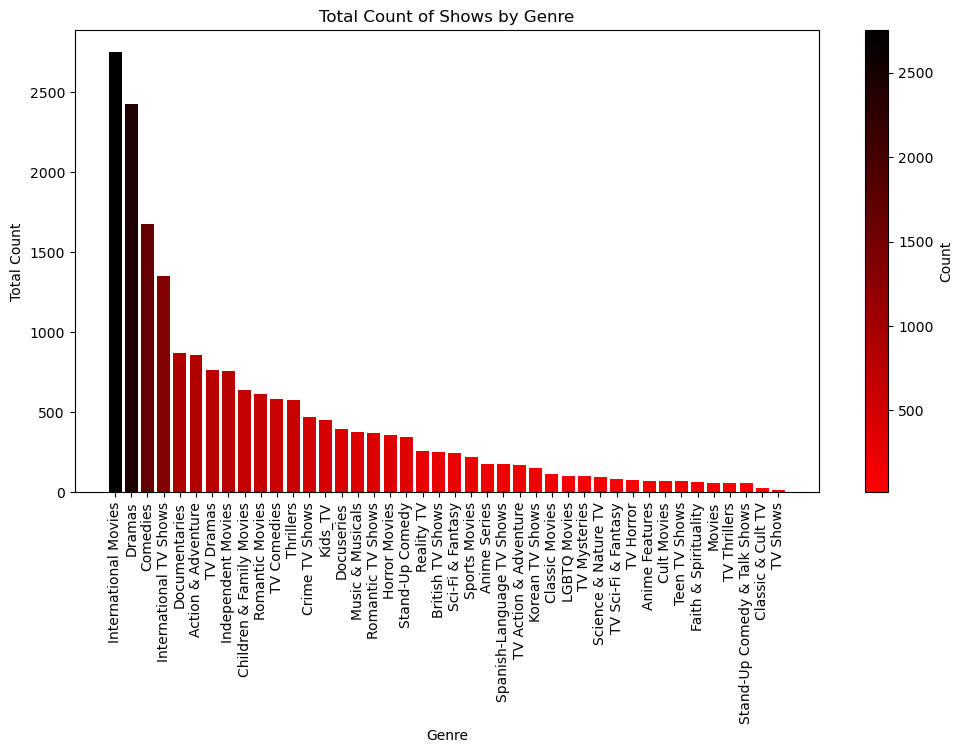

In [23]:
def visualize_genre_counts(df, genre_cols, colormap):
    # 장르 열의 값을 합산하여 총 합 계산
    genre_counts = df[genre_cols].sum()

    # 값이 높은 순서대로 정렬
    genre_counts_sorted = genre_counts.sort_values(ascending=False)

    # 그래프 크기 설정
    plt.figure(figsize=(12, 6))

    # 컬러맵 생성
    cmap = LinearSegmentedColormap.from_list('custom', [(1, 0, 0), (0, 0, 0)])

    # 막대 그래프 그리기
    bars = plt.bar(genre_counts_sorted.index, genre_counts_sorted, color=cmap(genre_counts_sorted/genre_counts_sorted.max()))

    # x 축 라벨 설정
    plt.xlabel('Genre')

    # y 축 라벨 설정
    plt.ylabel('Total Count')

    # 제목 설정
    plt.title('Total Count of Shows by Genre')

    # x 축 눈금 라벨 회전
    plt.xticks(rotation=90)

    # 컬러바 설정
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=genre_counts_sorted.min(), vmax=genre_counts_sorted.max()))
    sm._A = []
    cbar = plt.colorbar(sm)
    cbar.set_label('Count')

    # 그리드 추가
    # plt.grid(True)

    # 그래프 출력
    plt.show()

# 함수 호출
visualize_genre_counts(df, genre_cols, 'custom')


(5569, 54)


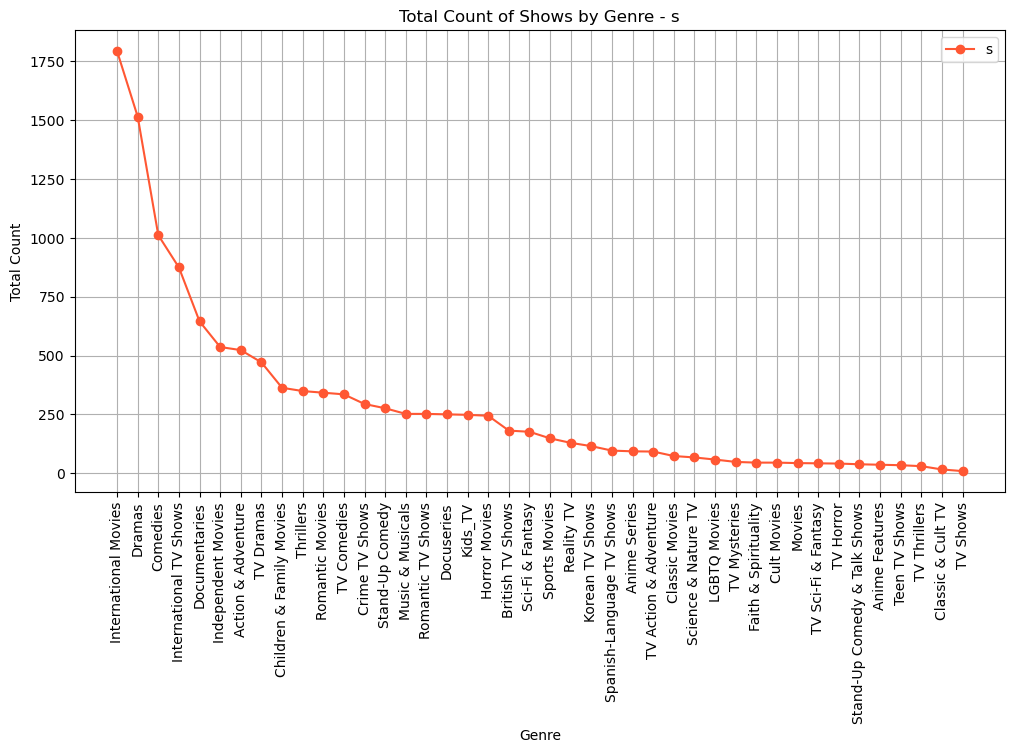

(3172, 54)


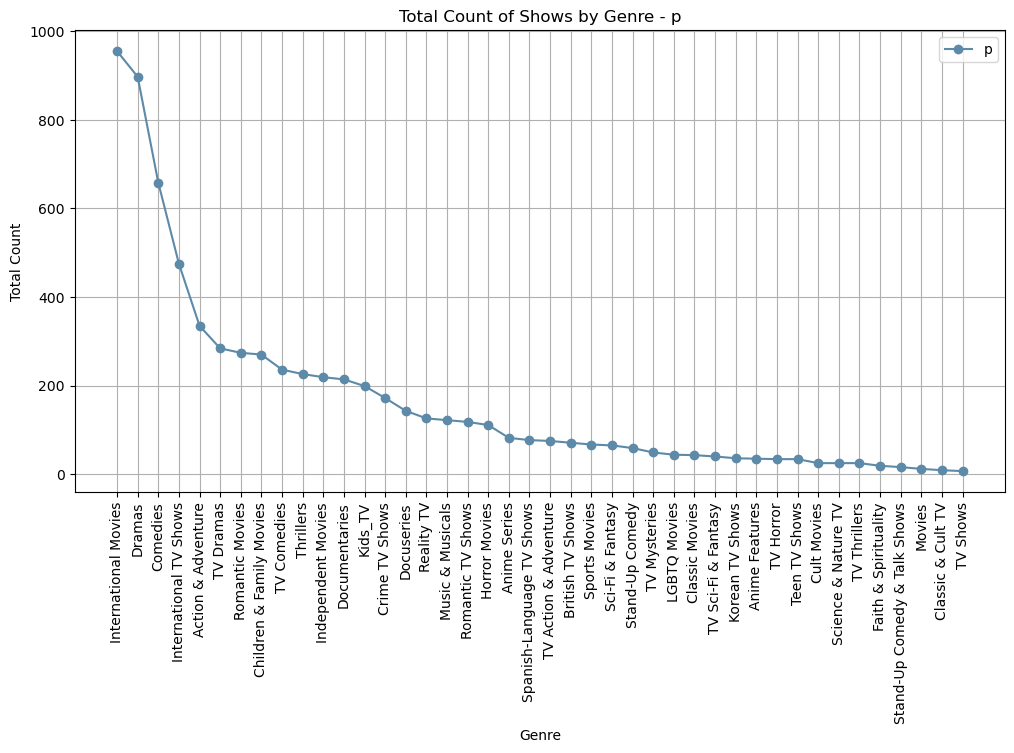

(0, 54)


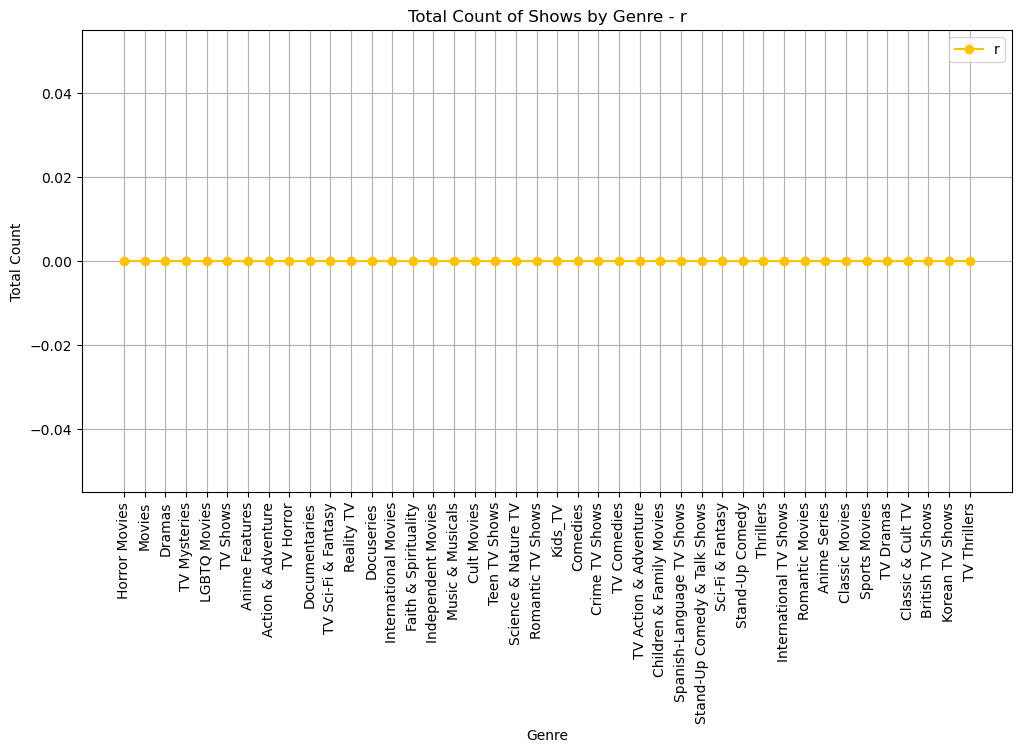

In [24]:
def visualize_genre_counts_line(df, genre_cols, period, color):
    # 해당 기간에 해당하는 데이터프레임 선택
    period_df = df[df['period'] == period]
    print(period_df.shape)  # 1. 해당 기간에 해당하는 데이터프레임이 올바르게 선택되었는지 확인

    # 장르 열의 값을 합산하여 총 합 계산
    genre_counts = period_df[genre_cols].sum()
    # print(genre_counts)  # 2. 장르 카운트가 올바르게 계산되었는지 확인

    # 값이 높은 순서대로 정렬
    genre_counts_sorted = genre_counts.sort_values(ascending=False)

    # 그래프 크기 설정
    plt.figure(figsize=(12, 6))

    # 라인 그래프 그리기
    plt.plot(genre_counts_sorted.index, genre_counts_sorted, marker='o', color=color, label=period)

    # x 축 라벨 설정
    plt.xlabel('Genre')

    # y 축 라벨 설정
    plt.ylabel('Total Count')

    # 제목 설정
    plt.title(f'Total Count of Shows by Genre - {period}')

    # x 축 눈금 라벨 회전
    plt.xticks(rotation=90)

    # 범례 표시
    plt.legend()

    # 그리드 추가
    plt.grid(True)

    # 그래프 출력
    plt.show()

# 함수 호출
visualize_genre_counts_line(df, genre_cols, 's', '#FF5733')  # 정체기 기간 - 주황색
visualize_genre_counts_line(df, genre_cols, 'p', '#5D8AA8')  # 펜데믹 기간 - 파란색
visualize_genre_counts_line(df, genre_cols, 'r', '#FFC300')  # 회복기 기간 - 노란색


### Total Count of Shows by Genre (Excluding Recovery Period)

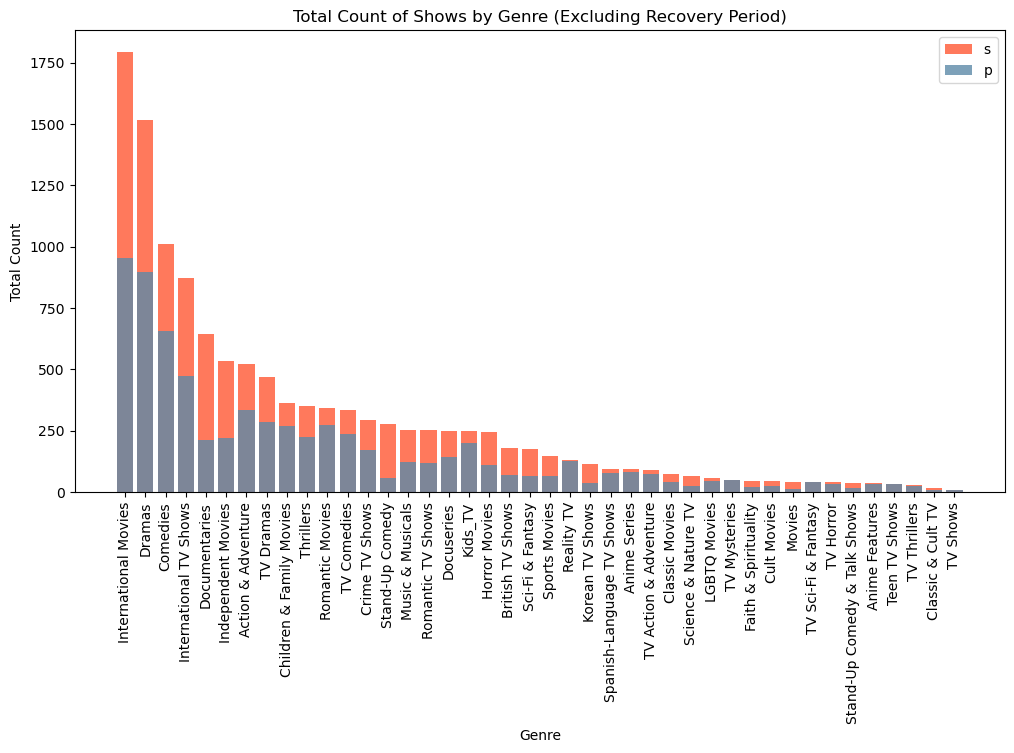

In [25]:
import matplotlib.pyplot as plt

def visualize_genre_counts_bar(df, genre_cols, period, color, alpha):
    # 해당 기간에 해당하는 데이터프레임 선택 (period가 'r'이 아닌 경우만 선택)
    period_df = df[df['period'] == period]

    # 장르 열의 값을 합산하여 총 합 계산
    genre_counts = period_df[genre_cols].sum()

    # 값이 높은 순서대로 정렬
    genre_counts_sorted = genre_counts.sort_values(ascending=False)

    # 막대 그래프 그리기
    plt.bar(genre_counts_sorted.index, genre_counts_sorted, color=color, alpha=alpha, label=period)


# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 정체기 기간 그래프 그리기
visualize_genre_counts_bar(df, genre_cols, 's', '#FF5733', alpha=0.8)  # 정체기 기간 - 주황색

# 펜데믹 기간 그래프 그리기
visualize_genre_counts_bar(df, genre_cols, 'p', '#5D8AA8', alpha=0.8)  # 펜데믹 기간 - 파란색

# x 축 라벨 설정
plt.xlabel('Genre')

# y 축 라벨 설정
plt.ylabel('Total Count')

# 제목 설정
plt.title('Total Count of Shows by Genre (Excluding Recovery Period)')

# x 축 눈금 라벨 회전
plt.xticks(rotation=90)

# 범례 표시
plt.legend()

# 그리드 추가
#plt.grid(True)

# 그래프 출력
plt.show()


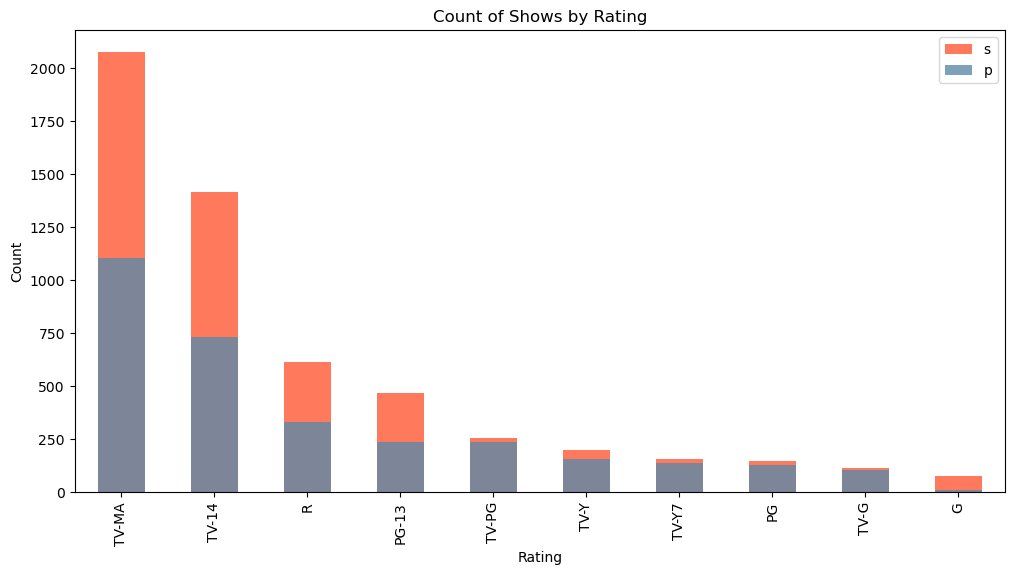

In [26]:
import matplotlib.pyplot as plt

def visualize_rating_counts_bar(df, period, color, alpha):
    # 해당 기간에 해당하는 데이터프레임 선택
    period_df = df[df['period'] == period]

    # rating 열의 값 카운트
    rating_counts = period_df['rating'].value_counts()

    # 막대 그래프 그리기
    rating_counts.plot(kind='bar', color=color, alpha=alpha, label=period)


# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 정체기 기간 그래프 그리기
visualize_rating_counts_bar(df, 's', '#FF5733', alpha=0.8)  # 정체기 기간 - 주황색

# 펜데믹 기간 그래프 그리기
visualize_rating_counts_bar(df, 'p', '#5D8AA8', alpha=0.8)  # 펜데믹 기간 - 파란색

# x 축 라벨 설정
plt.xlabel('Rating')

# y 축 라벨 설정
plt.ylabel('Count')

# 제목 설정
plt.title('Count of Shows by Rating')

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()

In [27]:
df['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', '74 min', '84 min', '66 min', 'NR', nan,
       'TV-Y7-FV', 'UR'], dtype=object)

## Korea

In [28]:
df_ko = df[df['country'] == 'South Korea']

### Distribution of Types_ko

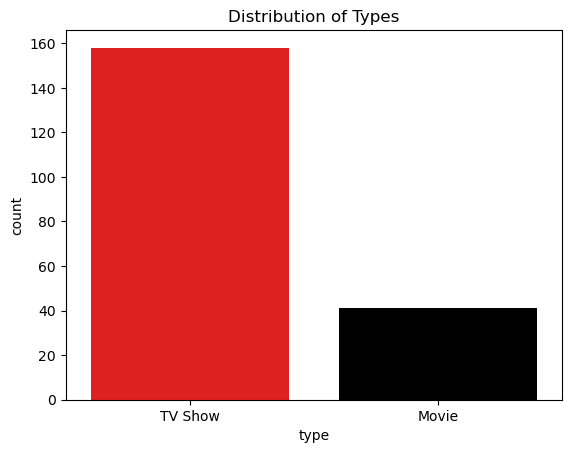

In [29]:
visualize_type_distribution(df_ko)

### Monthly Resampling & Cumulative Total show ID_Ko

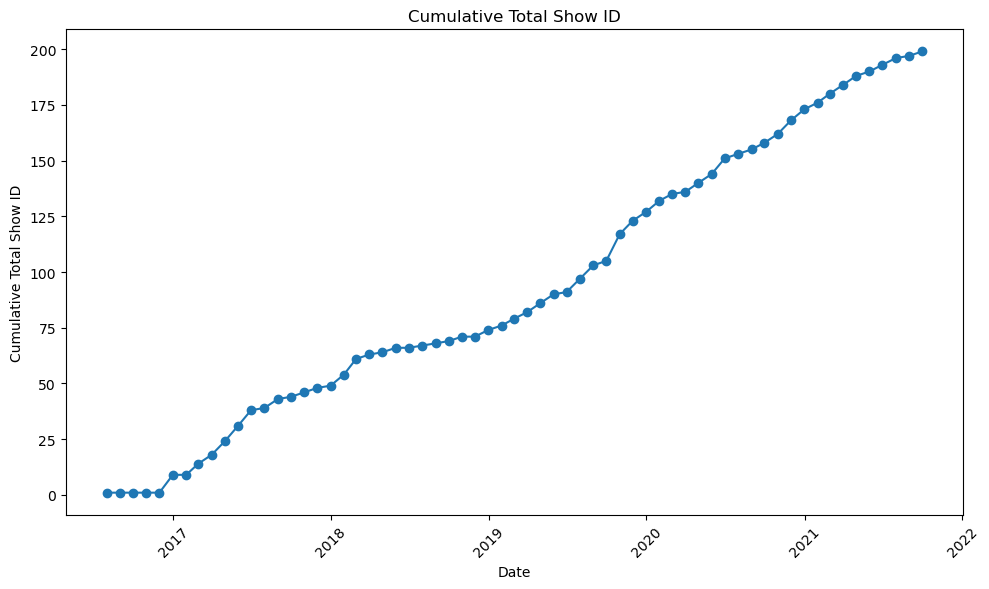

In [30]:
visualize_cumulative_total(df_ko)

### Count of Shows by Genre_ko

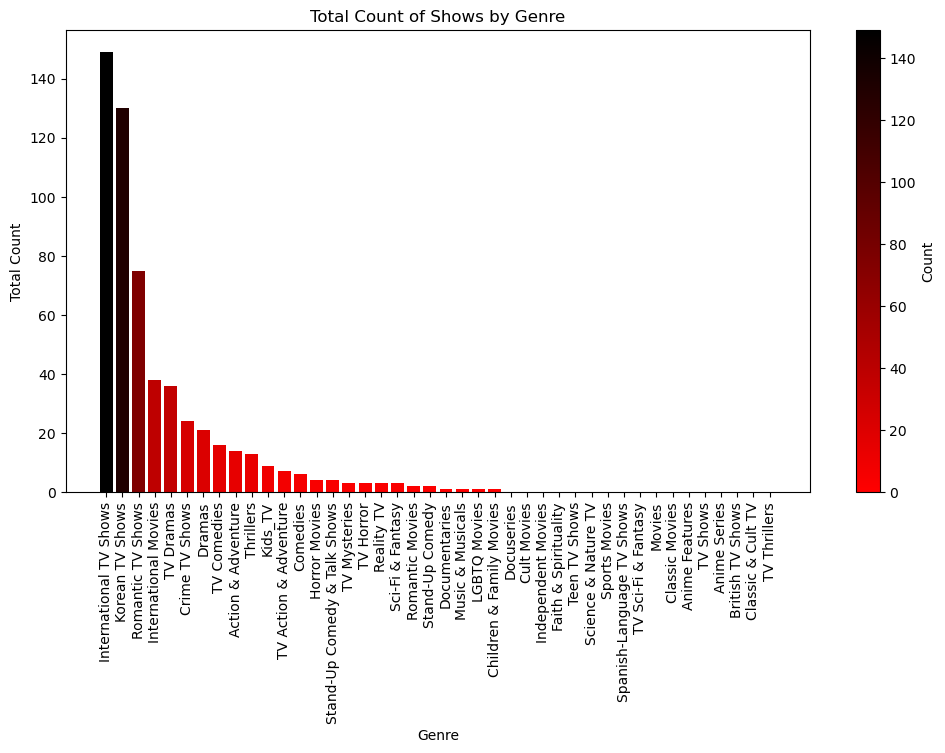

In [31]:
visualize_genre_counts(df_ko, genre_cols, 'custom')

### Total Count of Shows by Genre (Excluding Recovery Period)_ko

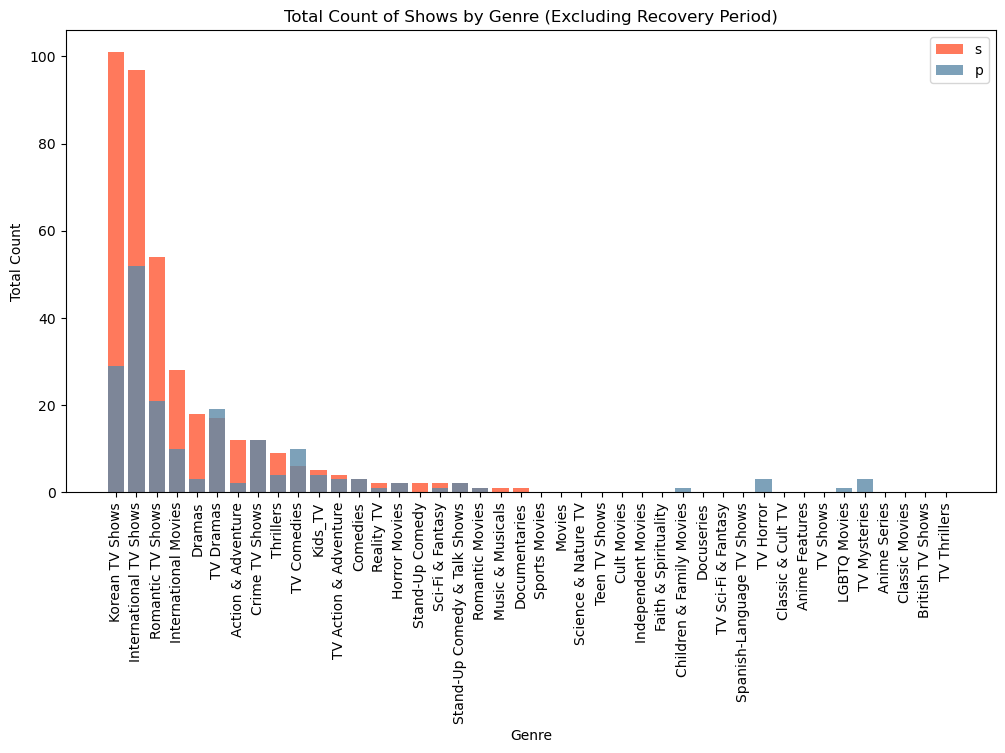

In [32]:
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 정체기 기간 그래프 그리기
visualize_genre_counts_bar(df_ko, genre_cols, 's', '#FF5733', alpha=0.8)  # 정체기 기간 - 주황색

# 펜데믹 기간 그래프 그리기
visualize_genre_counts_bar(df_ko, genre_cols, 'p', '#5D8AA8', alpha=0.8)  # 펜데믹 기간 - 파란색

# x 축 라벨 설정
plt.xlabel('Genre')

# y 축 라벨 설정
plt.ylabel('Total Count')

# 제목 설정
plt.title('Total Count of Shows by Genre (Excluding Recovery Period)')

# x 축 눈금 라벨 회전
plt.xticks(rotation=90)

# 범례 표시
plt.legend()

# 그리드 추가
#plt.grid(True)

# 그래프 출력
plt.show()


### Count of Shows by Rating

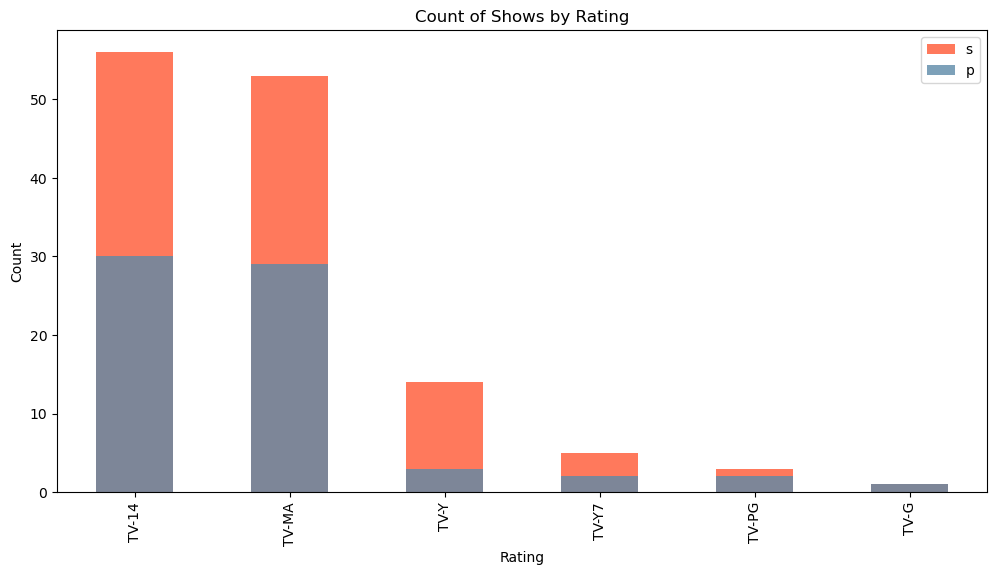

In [33]:
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 정체기 기간 그래프 그리기
visualize_rating_counts_bar(df_ko, 's', '#FF5733', alpha=0.8)  # 정체기 기간 - 주황색

# 펜데믹 기간 그래프 그리기
visualize_rating_counts_bar(df_ko, 'p', '#5D8AA8', alpha=0.8)  # 펜데믹 기간 - 파란색

# x 축 라벨 설정
plt.xlabel('Rating')

# y 축 라벨 설정
plt.ylabel('Count')

# 제목 설정
plt.title('Count of Shows by Rating')

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()

## Only Movie
- duration 평균/중앙값
- rating 분포

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8807 entries, 2021-09-25 to 2019-03-02
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   show_id                       8807 non-null   object
 1   type                          8807 non-null   object
 2   title                         8807 non-null   object
 3   director                      6173 non-null   object
 4   cast                          7982 non-null   object
 5   country                       7976 non-null   object
 6   release_year                  8807 non-null   int64 
 7   rating                        8803 non-null   object
 8   duration                      8804 non-null   object
 9   listed_in                     8807 non-null   object
 10  description                   8807 non-null   object
 11  International TV Shows        8807 non-null   int64 
 12  TV Thrillers                  8807 non-null   int64 
 13  

In [40]:
df_movie = df[df['type'] == 'Movie']
df_ko_movie = df_ko[df_ko['type'] == 'Movie']

In [41]:
df_ko_movie['rating'].value_counts()

TV-MA    32
TV-14     3
NR        3
TV-PG     2
TV-Y7     1
Name: rating, dtype: int64

### Top 20 Countries_movie

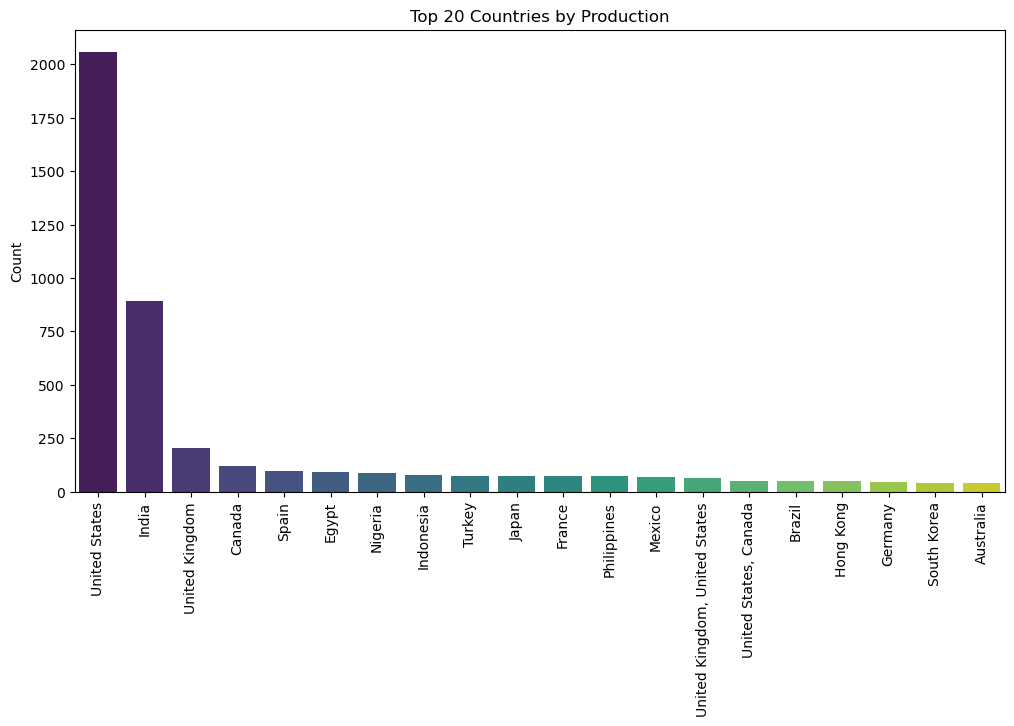

In [42]:
visualize_top_countries(df_movie) # 한국 영화는 순위에도 들지 못함

### Monthly Resampling & Cumulative Total show ID

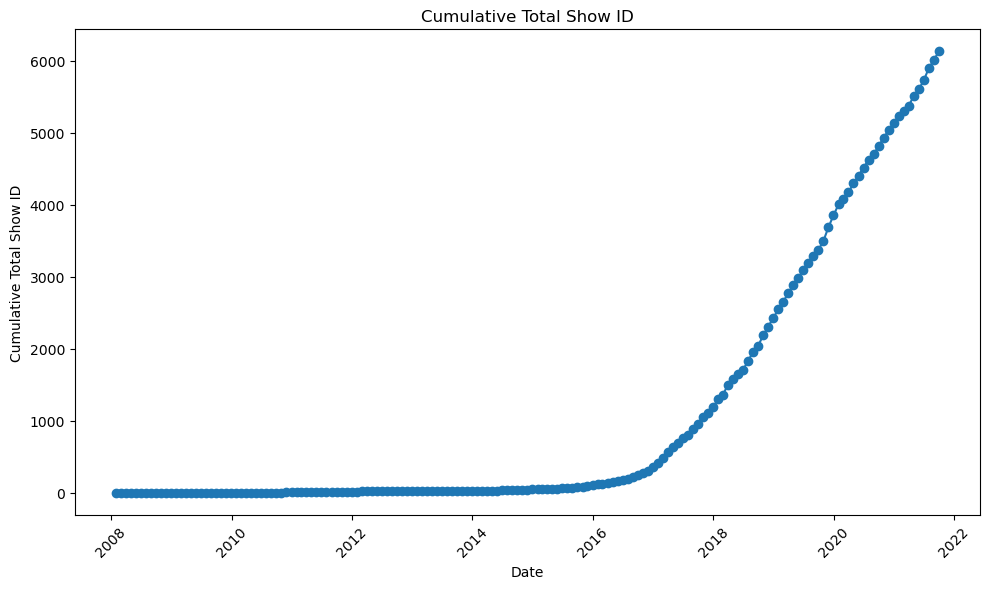

In [43]:
visualize_cumulative_total(df_movie)

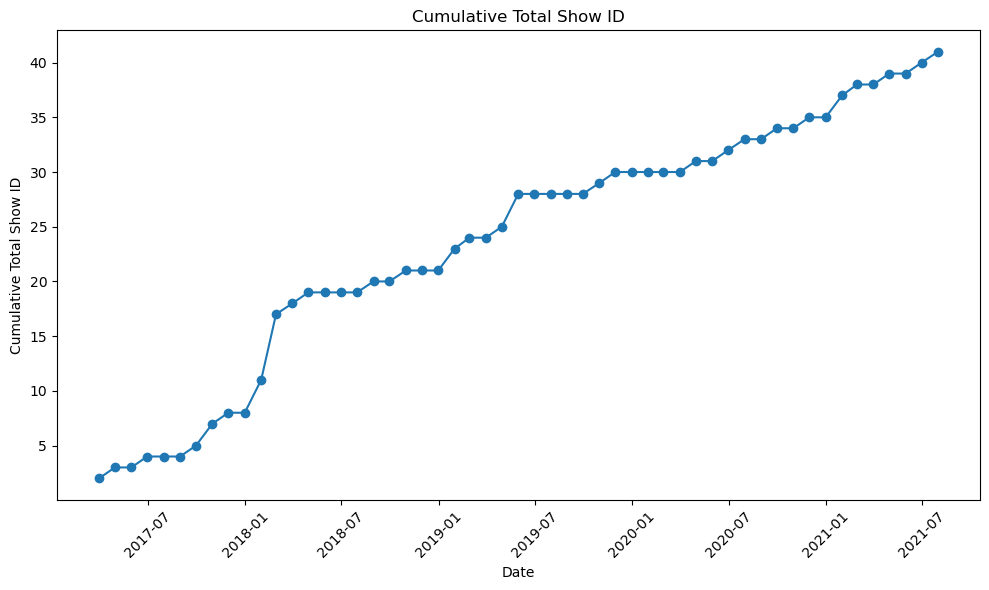

In [44]:
visualize_cumulative_total(df_ko_movie)

### Count of Shows by Genre_movie

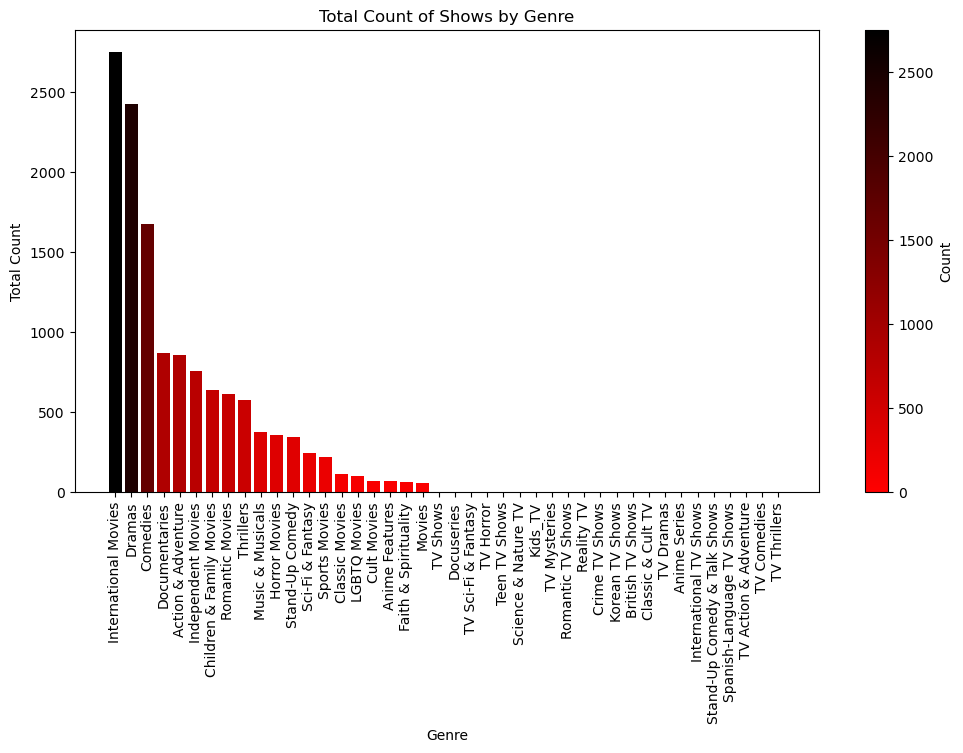

In [45]:
visualize_genre_counts(df_movie, genre_cols, 'custom')

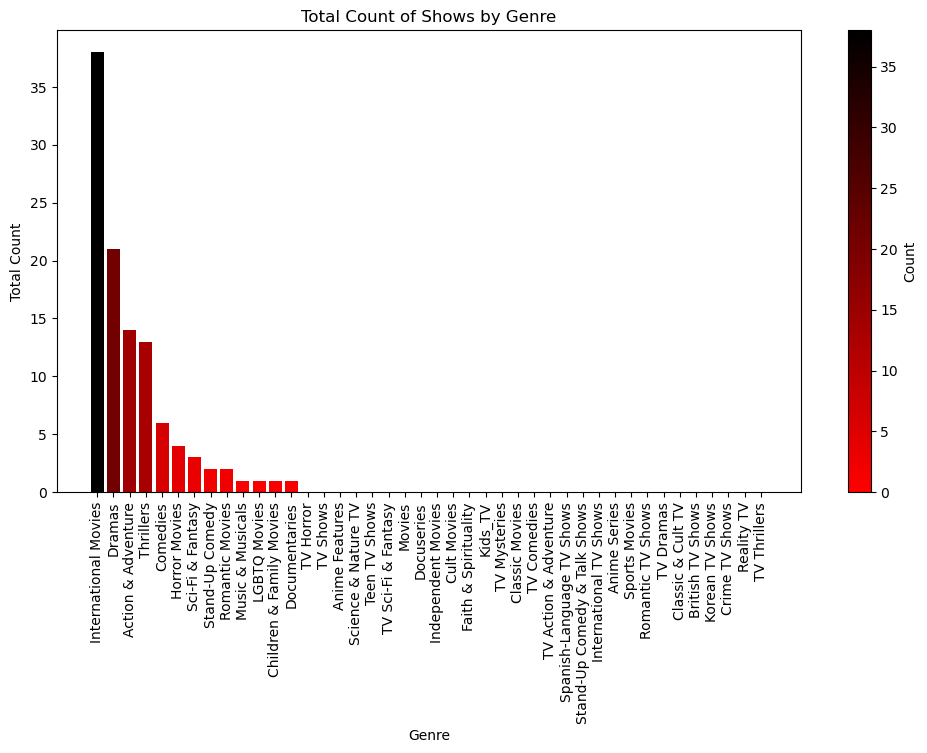

In [46]:
visualize_genre_counts(df_ko_movie, genre_cols, 'custom')

### Count of show ID by Period(S - 정체기, P - 팬데믹)_movie

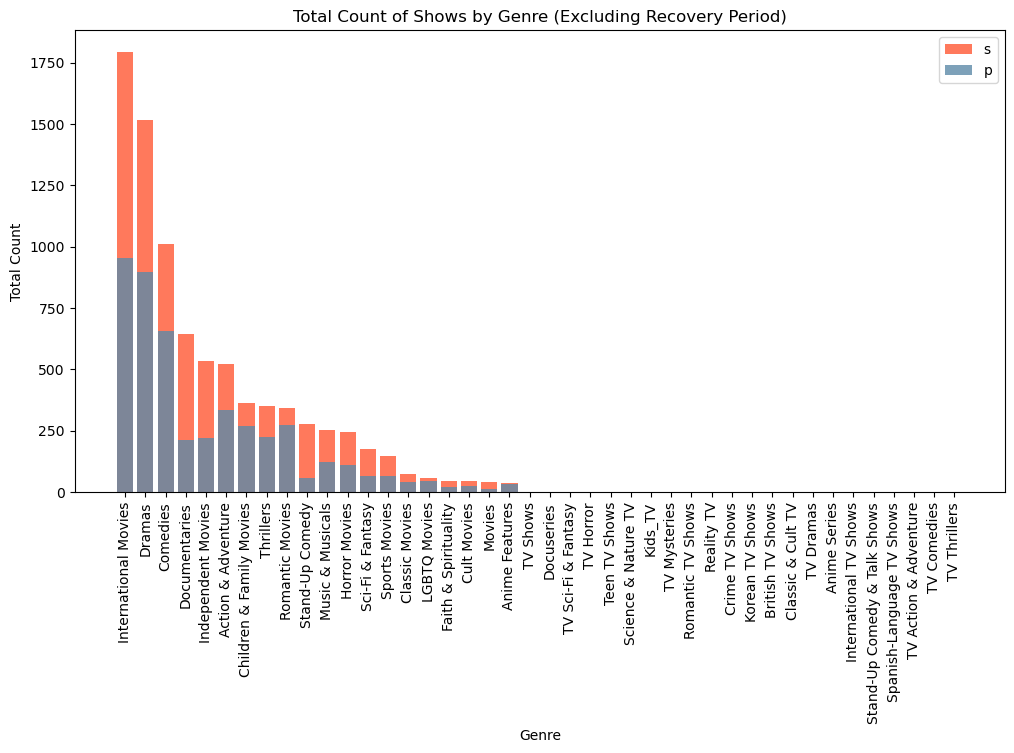

In [47]:
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 정체기 기간 그래프 그리기
visualize_genre_counts_bar(df_movie, genre_cols, 's', '#FF5733', alpha=0.8)  # 정체기 기간 - 주황색

# 펜데믹 기간 그래프 그리기
visualize_genre_counts_bar(df_movie, genre_cols, 'p', '#5D8AA8', alpha=0.8)  # 펜데믹 기간 - 파란색

# x 축 라벨 설정
plt.xlabel('Genre')

# y 축 라벨 설정
plt.ylabel('Total Count')

# 제목 설정
plt.title('Total Count of Shows by Genre (Excluding Recovery Period)')

# x 축 눈금 라벨 회전
plt.xticks(rotation=90)

# 범례 표시
plt.legend()

# 그리드 추가
#plt.grid(True)

# 그래프 출력
plt.show()


### Count of show ID by Period(S - 정체기, P - 팬데믹)_ko_movie

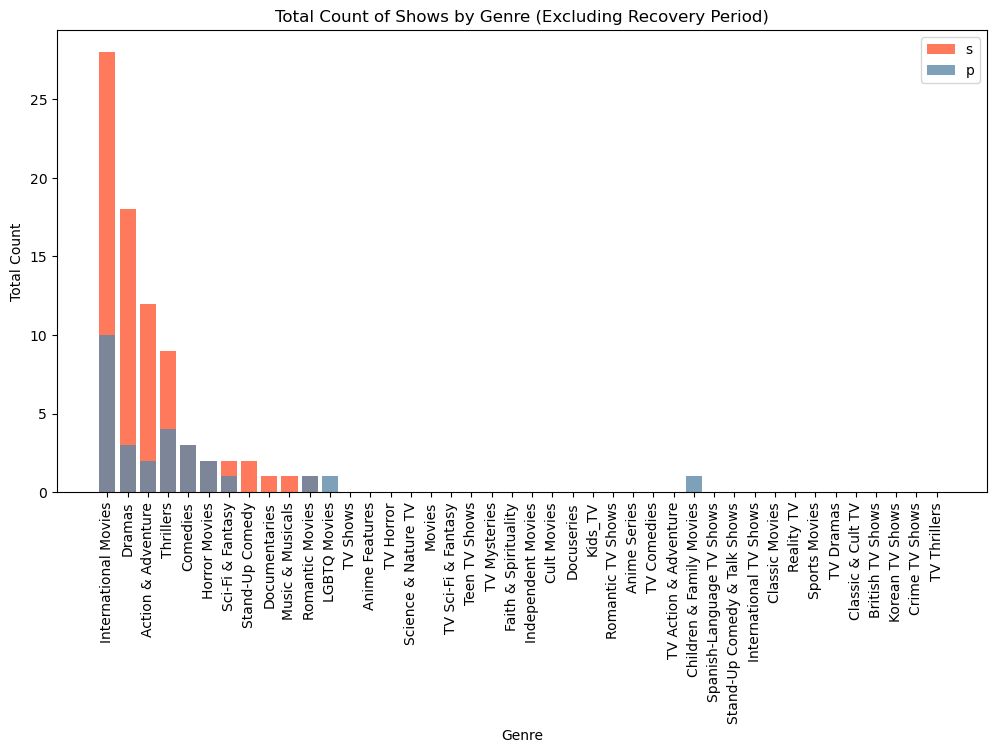

In [48]:
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 정체기 기간 그래프 그리기
visualize_genre_counts_bar(df_ko_movie, genre_cols, 's', '#FF5733', alpha=0.8)  # 정체기 기간 - 주황색

# 펜데믹 기간 그래프 그리기
visualize_genre_counts_bar(df_ko_movie, genre_cols, 'p', '#5D8AA8', alpha=0.8)  # 펜데믹 기간 - 파란색

# x 축 라벨 설정
plt.xlabel('Genre')

# y 축 라벨 설정
plt.ylabel('Total Count')

# 제목 설정
plt.title('Total Count of Shows by Genre (Excluding Recovery Period)')

# x 축 눈금 라벨 회전
plt.xticks(rotation=90)

# 범례 표시
plt.legend()

# 그리드 추가
#plt.grid(True)

# 그래프 출력
plt.show()


### Count of Shows by Rating_movie

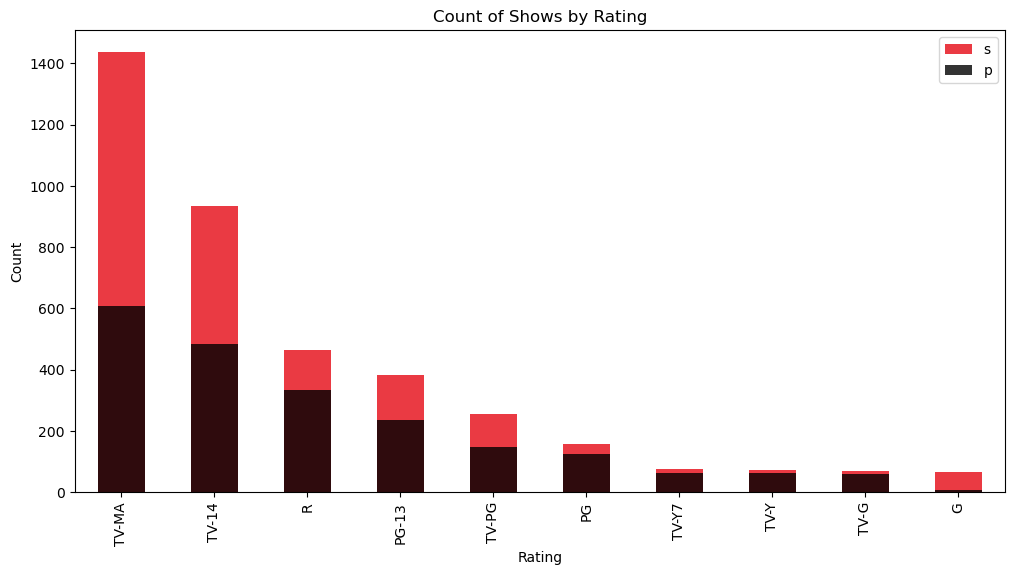

In [49]:
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 정체기 기간 그래프 그리기
visualize_rating_counts_bar(df_movie, 's', '#E50914', alpha=0.8)  # 정체기 기간 - 주황색

# 펜데믹 기간 그래프 그리기
visualize_rating_counts_bar(df_movie, 'p', '#000000', alpha=0.8)  # 펜데믹 기간 - 파란색

# x 축 라벨 설정
plt.xlabel('Rating')

# y 축 라벨 설정
plt.ylabel('Count')

# 제목 설정
plt.title('Count of Shows by Rating')

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()

### Count of Shows by Rating_ko_movie

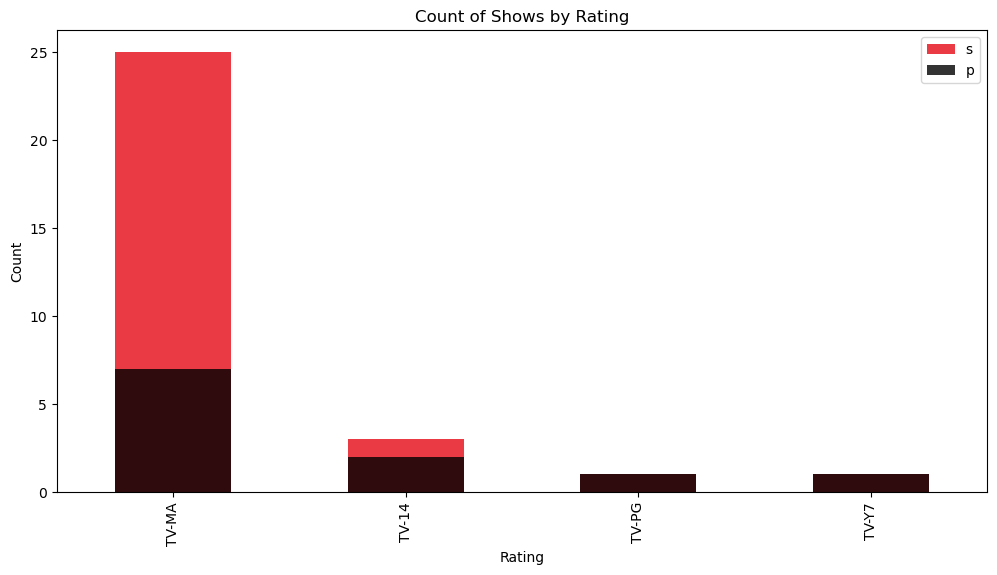

In [52]:
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 정체기 기간 그래프 그리기
visualize_rating_counts_bar(df_ko_movie, 's', '#E50914', alpha=0.8)  # 정체기 기간 - 주황색

# 펜데믹 기간 그래프 그리기
visualize_rating_counts_bar(df_ko_movie, 'p', '#000000', alpha=0.8)  # 펜데믹 기간 - 파란색

# x 축 라벨 설정
plt.xlabel('Rating')

# y 축 라벨 설정
plt.ylabel('Count')

# 제목 설정
plt.title('Count of Shows by Rating')

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()

## 시청률 데이터와 연결

In [55]:
data = pd.read_excel('../data/Engagement_Report_2023Jan-Jun.xlsx')

In [56]:
data

,Title,Available Globally?,Release Date,Hours Viewed
0,The Night Agent: Season 1,Yes,2023-03-23,812100000
1,Ginny & Georgia: Season 2,Yes,2023-01-05,665100000
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,2022-12-30,622800000
3,Wednesday: Season 1,Yes,2022-11-23,507700000
4,Queen Charlotte: A Bridgerton Story,Yes,2023-05-04,503000000
...,...,...,...,...
18209,راس السنة,No,NaT,100000
18210,心が叫びたがってるんだ。,No,NaT,100000
18211,두근두근 내 인생,No,NaT,100000
18212,라디오 스타,No,NaT,100000


In [57]:
df1 = data[data['Available Globally?'] == 'Yes']

In [74]:
import re

# Regular expression pattern to match Korean characters
korean_pattern = re.compile('[\u3131-\uD79D]+')

# Filter rows where the title contains Korean characters
korean_titles_df1 = df1[df1['Title'].str.contains(korean_pattern, na=False)]

In [75]:
korean_titles_df1

,Title,Available Globally?,Release Date,Hours Viewed
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,2022-12-30,622800000
14,Physical: 100: Season 1 // 피지컬: 100: 시즌 1,Yes,2023-01-24,235000000
15,Crash Course in Romance: Limited Series // 일타 ...,Yes,2023-01-14,234800000
24,Doctor Cha: Limited Series // 닥터 차정숙: 리미티드 시리즈,Yes,2023-04-15,194700000
39,Alice in Borderland: Season 2 // 今際の国のアリス: シーズン2,Yes,2022-12-22,157600000
...,...,...,...,...
17152,Sky Ladder: The Art of Cai Guo-Qiang // 天梯：蔡國強...,Yes,2016-10-14,100000
17417,The Could’ve-Gone-All-the-Way Committee: Seaso...,Yes,NaT,100000
17718,The Sound of Your Heart: Reboot: Season 2 // 마...,Yes,2018-12-02,100000
18038,Wassup Man GO!: Season 1 // 와썹맨 GO!: 시즌 1,Yes,NaT,100000


In [76]:
df_title = korean_titles_df1['Title'].tolist()

In [78]:
len(df_title)

423

In [64]:
# Assuming df1_title and df_title are your lists
overlap_count = len(set(df1_title) & set(df_title))
print("Number of overlapping items:", overlap_count)


Number of overlapping items: 875
